Anna Marjankowska, Adrian Żyła

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids, AllKNN
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score, confusion_matrix
from imblearn.metrics import specificity_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


## Roczny dochód obywateli USA.

Celem projektu jest przeprowadzenie **analizy eksploracyjnej danych** dotyczących dochodów obywateli USA oraz **budowa modeli predykcyjnych** w celu przewidywania poziomu dochodów. Analiza ma na celu zrozumienie kluczowych czynników wpływających na dochody oraz **ocenę interpretowalności zastosowanych modeli**. 

Źródło danych: https://www.kaggle.com/datasets/amirhosseinmirzaie/americancitizenincome/data

### 1. Wczytanie oraz analiza danych.

#### Opis zmiennych w zbiorze danych

- **age**: Wiek osoby.  
- **workclass**: Status zatrudnienia (np. pracownik sektora prywatnego, rządowego itp.).  
- **fnlwgt**: Waga reprezentatywna danej osoby w próbie.  
- **education**: Najwyższy poziom wykształcenia osiągnięty przez osobę (np. "Bachelors").  
- **education.num**: Liczbowy odpowiednik poziomu wykształcenia.  
- **marital.status**: Status cywilny (np. "Married-civ-spouse" - małżonek cywilny).  
- **occupation**: Typ zawodu (np. "Tech-support", "Craft-repair").  
- **relationship**: Relacja osoby z innymi (np. "Husband", "Own-child").  
- **race**: Rasa osoby (np. "White", "Black").  
- **sex**: Płeć biologiczna ("Male", "Female").  
- **capital.gain**: Dochody kapitałowe (zyski).  
- **capital.loss**: Straty kapitałowe.  
- **hours.per.week**: Liczba przepracowanych godzin tygodniowo.  
- **native.country**: Kraj pochodzenia osoby (np. "United-States").  
- **income**: Dochód osoby w jednej z dwóch kategorii: ≤50K lub >50K.



In [192]:
df = pd.read_csv("./income.csv")

In [193]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,United-States,>50K
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,>50K
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,United-States,>50K
4,54,?,148657,Preschool,1,Married-civ-spouse,?,Wife,White,Female,0,0,40,Mexico,<=50K


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             25000 non-null  int64 
 1   workclass       25000 non-null  object
 2   fnlwgt          25000 non-null  int64 
 3   education       25000 non-null  object
 4   education.num   25000 non-null  int64 
 5   marital.status  25000 non-null  object
 6   occupation      25000 non-null  object
 7   relationship    25000 non-null  object
 8   race            25000 non-null  object
 9   sex             25000 non-null  object
 10  capital.gain    25000 non-null  int64 
 11  capital.loss    25000 non-null  int64 
 12  hours.per.week  25000 non-null  int64 
 13  native.country  25000 non-null  object
 14  income          25000 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.9+ MB


Podstawowe statystyki zmiennych ilościowych:

In [195]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,25000.00000,2.500000e+04,25000.000000,25000.000000,25000.000000,25000.000000
mean,38.60916,1.896611e+05,10.076320,1083.144040,87.489800,40.442800
std,13.68660,1.054713e+05,2.576967,7321.971568,402.830246,12.309706
min,17.00000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.00000,1.179830e+05,9.000000,0.000000,0.000000,40.000000
50%,37.00000,1.782110e+05,10.000000,0.000000,0.000000,40.000000
75%,48.00000,2.370682e+05,12.000000,0.000000,0.000000,45.000000
max,90.00000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [196]:
def categorical_value_counts(data):
    categorical_cols = data.select_dtypes(include=['object']).columns 
    value_counts = {col: data[col].value_counts() for col in categorical_cols}
    return value_counts 

In [197]:
value_counts = categorical_value_counts(df)

for col, counts in value_counts.items():
    print(f"\nColumn: {col}")
    print(counts)



Column: workclass
workclass
Private             17471
Self-emp-not-inc     1935
Local-gov            1553
?                    1429
State-gov            1004
Self-emp-inc          851
Federal-gov           740
Without-pay            12
Never-worked            5
Name: count, dtype: int64

Column: education
education
HS-grad         8025
Some-college    5621
Bachelors       4104
Masters         1301
Assoc-voc       1063
11th             905
Assoc-acdm       809
10th             736
7th-8th          476
Prof-school      449
9th              403
12th             344
Doctorate        328
5th-6th          265
1st-4th          135
Preschool         36
Name: count, dtype: int64

Column: marital.status
marital.status
Married-civ-spouse       11518
Never-married             8204
Divorced                  3390
Separated                  792
Widowed                    766
Married-spouse-absent      312
Married-AF-spouse           18
Name: count, dtype: int64

Column: occupation
occupation
Prof-sp

In [198]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [199]:
df[df == "?"].count()

age                  0
workclass         1429
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1434
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     437
income               0
dtype: int64

Zaobserwowaliśmy, że w zmiennych **workclass**, **occupation** oraz **native.region** występują braki w postaci $?$.  
Sprawdźmy najpierw zależność między zmiennymi. 

In [200]:
# Funkcja do obliczania V-Cramera
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

def cramers_v_output(v_cramer, variable1, variable2):
    print(f"V-Cramer dla zmiennych {variable1} & {variable2}: {v_cramer}")

    # Interpretacja wyniku
    if v_cramer < 0.1:
        print("Bardzo słaba zależność\n")
    elif v_cramer < 0.3:
        print("Słaba zależność\n")
    elif v_cramer < 0.5:
        print("Umiarkowana zależność\n")
    else:
        print("Silna zależność\n")

In [201]:
contingency_tables = {
    'relationship_marital.status': pd.crosstab(df['relationship'], df['marital.status']),
    'workclass_occupation': pd.crosstab(df['workclass'], df['occupation']),
    'race_native.country': pd.crosstab(df['race'], df['native.country'])
}

for table_name, table in contingency_tables.items():
    v_cramer = cramers_v(table)
    variable1, variable2 = table_name.split('_')
    cramers_v_output(v_cramer, variable1, variable2)

V-Cramer dla zmiennych relationship & marital.status: 0.4890628765894769
Umiarkowana zależność

V-Cramer dla zmiennych workclass & occupation: 0.39858811874024
Umiarkowana zależność

V-Cramer dla zmiennych race & native.country: 0.41116173339470086
Umiarkowana zależność



In [202]:
df[(df['occupation'] == "?") & (df['workclass'] != "?")]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
4445,18,Never-worked,153663,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K
16567,18,Never-worked,206359,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
19693,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,<=50K
20686,17,Never-worked,237272,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,<=50K
24280,23,Never-worked,188535,7th-8th,4,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,<=50K


In [203]:
df[(df['occupation'] != "?") & (df['workclass'] == "?")]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income


Jak widzimy zmienne **wokclass** i **occupation** są umiarkowanie zależne. Dodatkowo wartości brakujące znajdują się dla tych zmiennych w tych samych wierszach. Może to świadczyć o tym, że braki w danych nie są przypadkowe, może to wskazywać na celowe zatajenie tej informacji.  
Zamienimy więc wartości $?$ w zmiennych workclass & occupation na nową kategorię **unknown**.

In [204]:
df['occupation'].replace("?", "unknown", inplace=True)
df['workclass'].replace('?', 'unknown', inplace=True )


/var/folders/hh/pvrf3bcn1_19pfvwcv0z6n_m0000gn/T/ipykernel_81119/1561306353.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['occupation'].replace("?", "unknown", inplace=True)
/var/folders/hh/pvrf3bcn1_19pfvwcv0z6n_m0000gn/T/ipykernel_81119/1561306353.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [205]:
df[df == "?"].count()

age                 0
workclass           0
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation          0
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    437
income              0
dtype: int64

Dla zmiennej **native.country** zamienimy $?$ na $NA$, aby następnie w prosty sposób usunąć te wiersze ze zbioru. 

In [206]:
df['native.country'].replace("?", np.nan, inplace=True)

/var/folders/hh/pvrf3bcn1_19pfvwcv0z6n_m0000gn/T/ipykernel_81119/248681289.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['native.country'].replace("?", np.nan, inplace=True)


In [207]:
df = df.dropna()

In [208]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

Zweryfikujmy teraz zależność zmiennej **native.country** i **race**:

In [209]:
contingency_tables = pd.crosstab(df['race'], df['native.country'])
v_cramer = cramers_v(contingency_tables)
cramers_v_output(v_cramer, 'race', 'native.country')

V-Cramer dla zmiennych race & native.country: 0.4236450220561596
Umiarkowana zależność



Usunięcie brakujących wartości ze zmiennej **native.country** **_nie wpłynęło na zależność_** ze zmienną **race**.

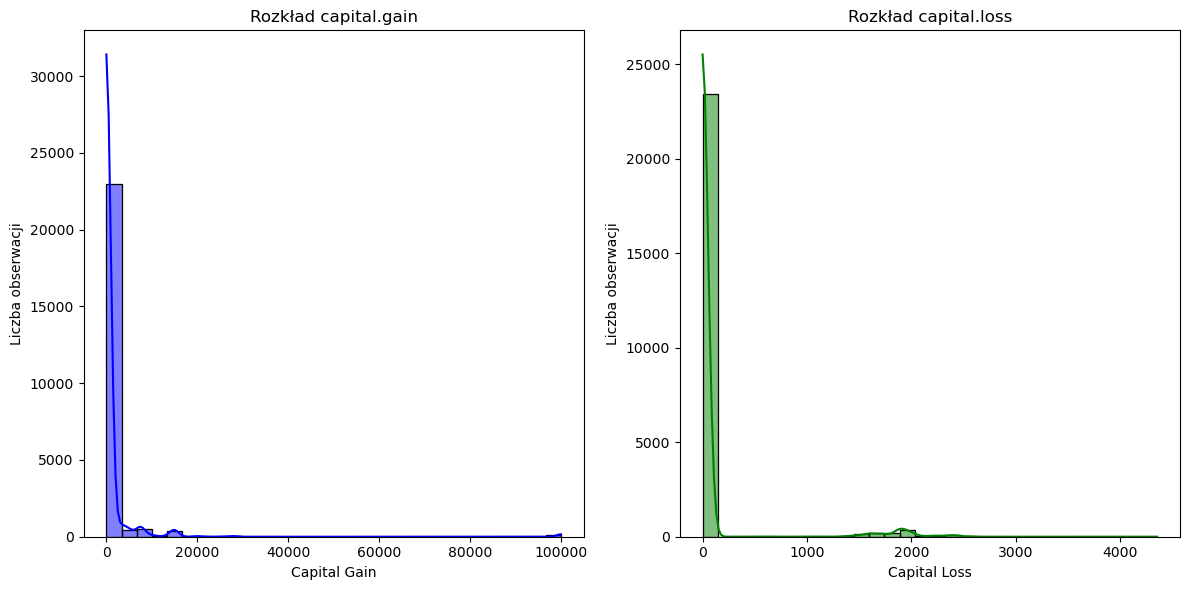

In [210]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['capital.gain'], bins=30, kde=True, color='blue')
plt.title('Rozkład capital.gain')
plt.xlabel('Capital Gain')
plt.ylabel('Liczba obserwacji')

plt.subplot(1, 2, 2)
sns.histplot(df['capital.loss'], bins=30, kde=True, color='green')
plt.title('Rozkład capital.loss')
plt.xlabel('Capital Loss')
plt.ylabel('Liczba obserwacji')

plt.tight_layout()
plt.show()

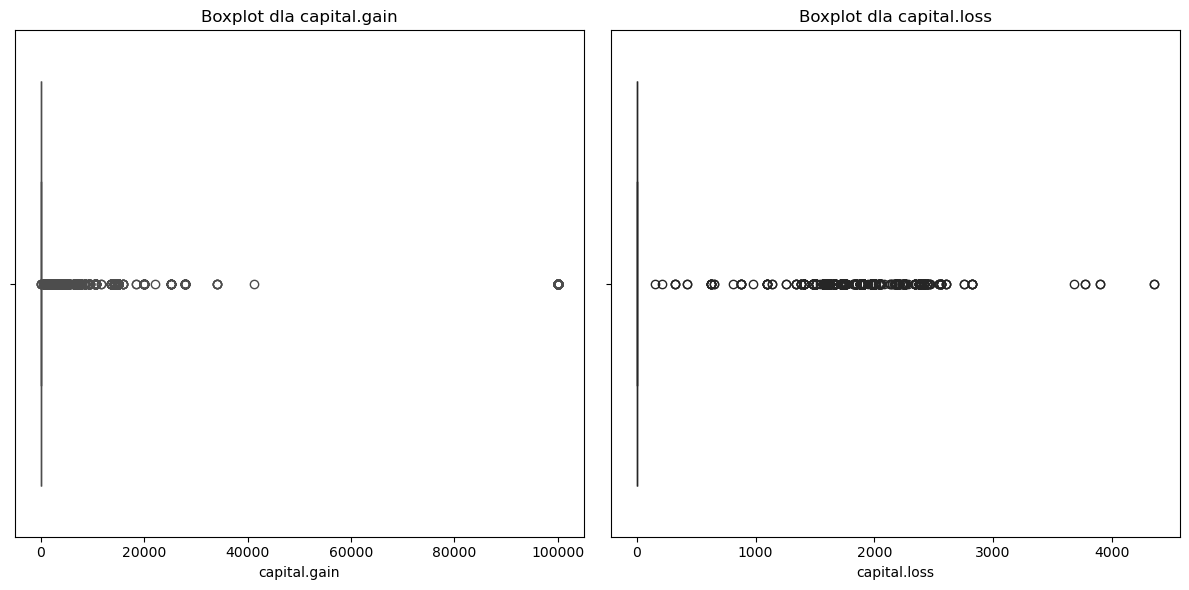

In [211]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['capital.gain'], color='blue')
plt.title('Boxplot dla capital.gain')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['capital.loss'], color='green')
plt.title('Boxplot dla capital.loss')

plt.tight_layout()
plt.show()

Zmienne **capital.loss** oraz **capital.gain** również są od siebie zależne. Możemy je zamienić na jedną zmienną **net.capital**.

In [212]:
df.loc[:, 'net.capital'] = df['capital.gain'] - df['capital.loss']
print(df[['capital.gain', 'capital.loss', 'net.capital']].head())

   capital.gain  capital.loss  net.capital
0         99999             0        99999
1             0             0            0
2             0             0            0
3             0             0            0
4             0             0            0


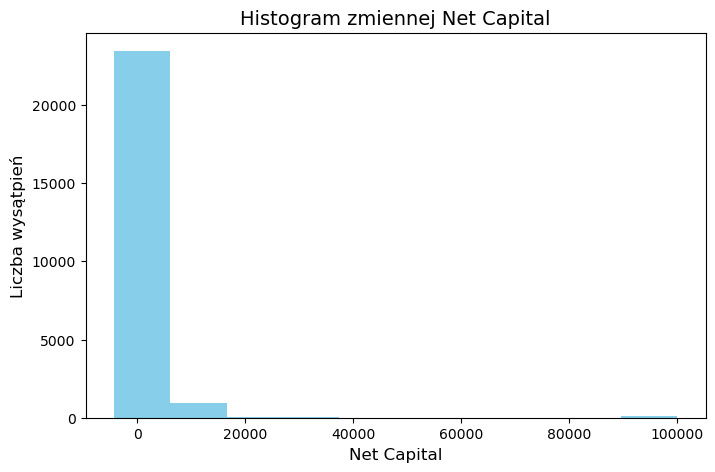

In [213]:
plt.figure(figsize=(8, 5))
plt.hist(df['net.capital'], color='skyblue')

plt.title("Histogram zmiennej Net Capital", fontsize=14)
plt.xlabel("Net Capital", fontsize=12)
plt.ylabel("Liczba wysątpień", fontsize=12)

plt.show()

In [214]:
df.drop(columns=['capital.gain', 'capital.loss'])

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income,net.capital
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,70,United-States,>50K,99999
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,40,United-States,<=50K,0
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,40,United-States,>50K,0
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,60,United-States,>50K,0
4,54,unknown,148657,Preschool,1,Married-civ-spouse,unknown,Wife,White,Female,40,Mexico,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24994,70,Private,278139,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,40,United-States,<=50K,3432
24995,40,Private,130834,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,40,United-States,<=50K,0
24996,31,Local-gov,33124,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,50,United-States,<=50K,0
24998,23,Private,420973,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,40,United-States,<=50K,0


Zmienna **native.country** składa się z wielu kategorii. W celu jej uproszczenia postanowiliśmy zmapować ją do nowej kategorii **native.region**.

In [215]:
region_mapping = {
    'Cambodia': 'Asia',
    'Canada': 'North America',
    'China': 'Asia',
    'Columbia': 'South America',
    'Cuba': 'Caribbean',
    'Dominican-Republic': 'Caribbean',
    'Ecuador': 'South America',
    'El-Salvador': 'Central America',
    'England': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Greece': 'Europe',
    'Guatemala': 'Central America',
    'Haiti': 'Caribbean',
    'Honduras': 'Central America',
    'Hong': 'Asia',
    'Hungary': 'Europe',
    'India': 'Asia',
    'Iran': 'Middle East',
    'Ireland': 'Europe',
    'Italy': 'Europe',
    'Jamaica': 'Caribbean',
    'Japan': 'Asia',
    'Laos': 'Asia',
    'Mexico': 'North America',
    'Nicaragua': 'Central America',
    'Outlying-US(Guam-USVI-etc)': 'US Territories',
    'Peru': 'South America',
    'Philippines': 'Asia',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Puerto-Rico': 'Caribbean',
    'Scotland': 'Europe',
    'South': 'Asia',
    'Taiwan': 'Asia',
    'Thailand': 'Asia',
    'Trinadad&Tobago': 'Caribbean',
    'United-States': 'North America',
    'Vietnam': 'Asia',
    'Yugoslavia': 'Europe'
}
df['native.region'] = df['native.country'].replace(region_mapping)

df = df.drop(columns=['native.country'])

df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,income,net.capital,native.region
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,>50K,99999,North America
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,<=50K,0,North America
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,>50K,0,North America
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,>50K,0,North America
4,54,unknown,148657,Preschool,1,Married-civ-spouse,unknown,Wife,White,Female,0,0,40,<=50K,0,North America


In [216]:
contingency_tables = pd.crosstab(df['race'], df['native.region'])
v_cramer = cramers_v(contingency_tables)
cramers_v_output(v_cramer, 'race', 'native.region')

V-Cramer dla zmiennych race & native.region: 0.40166173442827624
Umiarkowana zależność



Po zmapowaniu zmiennej **native.country** na zmienną **native.region** wciąż mamy umiarkowaną zależność.  

Zmienne **native.region** & **race**, **workclass** & **occupation** oraz **relationship** & **marital.status** wykazują umiarkowaną zależność. Aby zdecydować, którą zmienną uwzględnić w modelu, obliczymy ich wartość **IV (Information Value)**.

#### Czym jest WOE i IV?

1. **Weight of Evidence (WOE)**  
WOE to miara różnic między rozkładami dwóch grup (np. "good" vs "bad"). Używana w modelach logistycznych, normalizuje dane i obliczana jest jako:

$$
WOE = \ln\left(\frac{\% \text{good}}{\% \text{bad}}\right)
$$

2. **Information Value (IV)**  
IV ocenia siłę predykcyjną zmiennej względem zmiennej celu, bazując na WOE:

$$
IV = \sum_{i=1}^{n} \left(\% \text{good}_i - \% \text{bad}_i\right) \cdot WOE_i
$$

**Interpretacja IV:**  
- IV < 0.02: brak predykcyjnej mocy,  
- 0.02 ≤ IV < 0.1: słaba,  
- 0.1 ≤ IV < 0.3: umiarkowana,  
- IV ≥ 0.3: silna.


**Dlaczego stosujemy WOE i IV?**  
- **WOE**: Normalizuje dane i zamienia zmienne kategoryczne na liczby dla modeli logistycznych.  
- **IV**: Identyfikuje zmienne o największej sile predykcyjnej. Pozwala rozróżnić, jak dobrze dana zmienna odróżnia grupy. Zmienna o wysokim IV lepiej pomaga w klasyfikacji, podczas gdy zmienna o niskim IV ma małą lub żadną moc predykcyjną.  

Obie miary pomagają w selekcji zmiennych, analizie danych i budowie stabilnych modeli.


Zamiana zmiennej **income** na zmienną binarną:

In [217]:
df = pd.get_dummies(df,columns=['income'], drop_first=True, dtype=int)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,net.capital,native.region,income_>50K
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,99999,North America,1
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,0,North America,0
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,0,North America,1
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,0,North America,1
4,54,unknown,148657,Preschool,1,Married-civ-spouse,unknown,Wife,White,Female,0,0,40,0,North America,0


In [218]:
# Funkcja do obliczenia WoE i IV
def calculate_woe_iv(data, feature, target):

    df = data[[feature, target]].copy()
    total_good = df[target].sum() 
    total_bad = len(df) - total_good  
    
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped['bad'] = grouped['count'] - grouped['sum']
    grouped['good_dist'] = grouped['sum'] / total_good
    grouped['bad_dist'] = grouped['bad'] / total_bad

    grouped['woe'] = np.log((grouped['good_dist'] + 1e-6) / (grouped['bad_dist'] + 1e-6))
    grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']

    total_iv = grouped['iv'].sum()
    grouped = grouped.reset_index()
    return grouped, total_iv


In [219]:
# Obliczenie WoE i IV dla kolumny 'education'
dependent_col = ['native.region', 'race', 'workclass', 'occupation', 'relationship', 'marital.status']

for col in dependent_col:
    woe_iv_df, total_iv = calculate_woe_iv(df, col, 'income_>50K')
    print(f"\nWartość IV dla zmiennej {col}: {total_iv:.4f}")


Wartość IV dla zmiennej native.region: 0.0282

Wartość IV dla zmiennej race: 0.0627

Wartość IV dla zmiennej workclass: 0.1649

Wartość IV dla zmiennej occupation: 0.8165

Wartość IV dla zmiennej relationship: 1.5394

Wartość IV dla zmiennej marital.status: 1.3277


Na podstawie wartości **IV (Information Value)**, które wskazują siłę predykcyjną zmiennych, dokonano analizy, które zmienne z zależnych par należy pozostawić w modelu:

1. **Para: `native.region` i `race`**
   - **native.region**: IV = 0.0282 (bardzo niska predykcyjna moc).  
   - **race**: IV = 0.0627 (nadal niska, ale lepsza).  

**Decyzja**: Pozostawiamy zmienną **race**, ponieważ ma nieco wyższą wartość IV i lepszą predykcyjną moc.

2. **Para: `workclass` i `occupation`**
   - **workclass**: IV = 0.1649 (umiarkowana predykcyjna moc).  
   - **occupation**: IV = 0.8165 (silna predykcyjna moc).  

**Decyzja**: Pozostawiamy zmienną **occupation**, ponieważ ma znacznie wyższą wartość IV i lepiej wyjaśnia zmienną celu.

3. **Para: `relationship` i `marital.status`**
   - **relationship**: IV = 1.5394 (bardzo silna predykcyjna moc).  
   - **marital.status**: IV = 1.3277 (również bardzo silna, ale niższa). 
    
**Decyzja**: Pozostawiamy zmienną **relationship**, ponieważ ma najwyższą wartość IV spośród obu zmiennych.

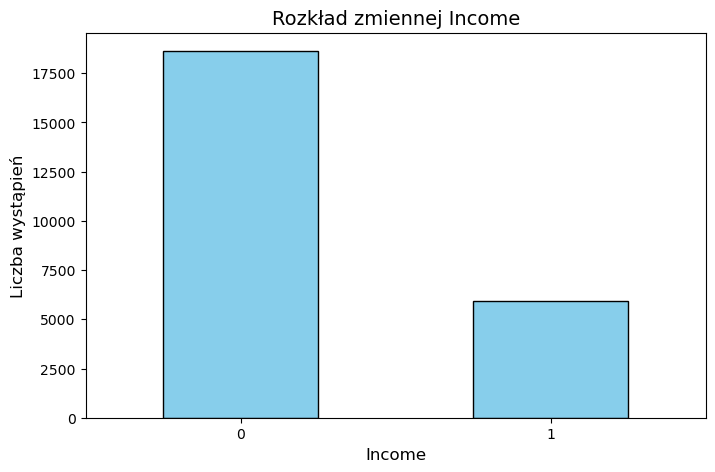

In [220]:
plt.figure(figsize=(8, 5))
df['income_>50K'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład zmiennej Income', fontsize=14)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Liczba wystąpień', fontsize=12)
plt.xticks(rotation=0)  # Ustawienie etykiet osi X poziomo

# Wyświetlenie wykresu
plt.show()


In [221]:
positive_class_ratio = (df['income_>50K'].value_counts()[1] / df['income_>50K'].count()) * 100
print(f"Klasa pozytywna stanowi {positive_class_ratio:.2f}% całego zbioru danych.")


Klasa pozytywna stanowi 24.16% całego zbioru danych.


Obliczyliśmy, że klasa pozytywna w naszym zbiorze danych, reprezentująca osoby o dochodzie powyżej $50K rocznie (`income_>50K`), stanowi **24.67%** całego zbioru danych.

**Co to oznacza?**

- Klasa pozytywna jest **mniejszością** w porównaniu do klasy negatywnej (dochód ≤ $50K).  
- Nasz zbiór danych jest niezbalansowany, co może wpłynąć na wydajność modeli predykcyjnych. Modele mogą być bardziej skłonne do przewidywania klasy dominującej (negatywnej), ignorując klasę pozytywną.

In [222]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,net.capital,native.region,income_>50K
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,99999,North America,1
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,0,North America,0
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,0,North America,1
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,0,North America,1
4,54,unknown,148657,Preschool,1,Married-civ-spouse,unknown,Wife,White,Female,0,0,40,0,North America,0


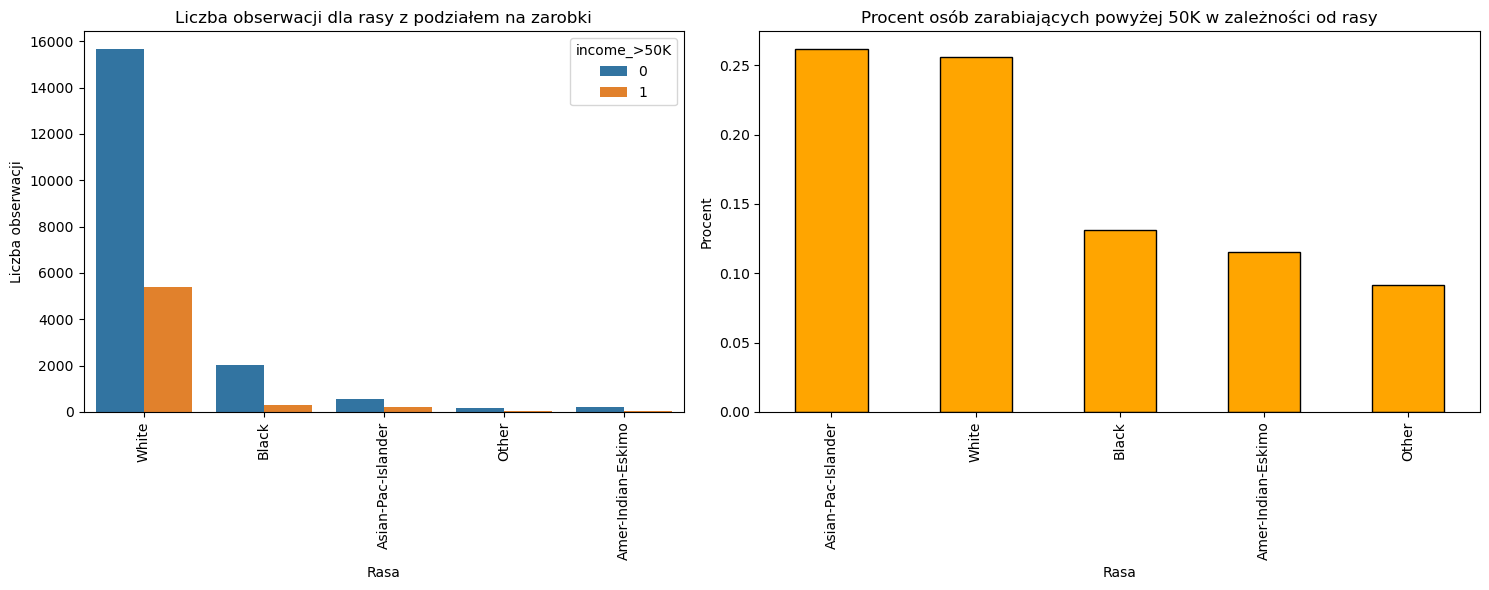

In [223]:
# Utworzenie figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1.2]})

# Wykres 1: Liczba obserwacji
sns.countplot(data=df, x='race', hue='income_>50K', ax=axes[0])
axes[0].set_title('Liczba obserwacji dla rasy z podziałem na zarobki')
axes[0].set_xlabel("Rasa")
axes[0].set_ylabel('Liczba obserwacji')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(title='income_>50K', loc='upper right')

# Obliczenie procentów
race_income = df.groupby(['race', 'income_>50K']).size().unstack()
race_percent = race_income.div(race_income.sum(axis=1), axis=0)

# Wykres 2: Procent osób zarabiających powyżej 50K
race_percent[1].sort_values(ascending=False).plot(
    kind='bar', color='orange', edgecolor='black', ax=axes[1]
)
axes[1].set_title('Procent osób zarabiających powyżej 50K w zależności od rasy')
axes[1].set_xlabel('Rasa')
axes[1].set_ylabel('Procent')
axes[1].tick_params(axis='x', rotation=90)

# Ustawienie odstępów między wykresami
plt.tight_layout()
plt.show()



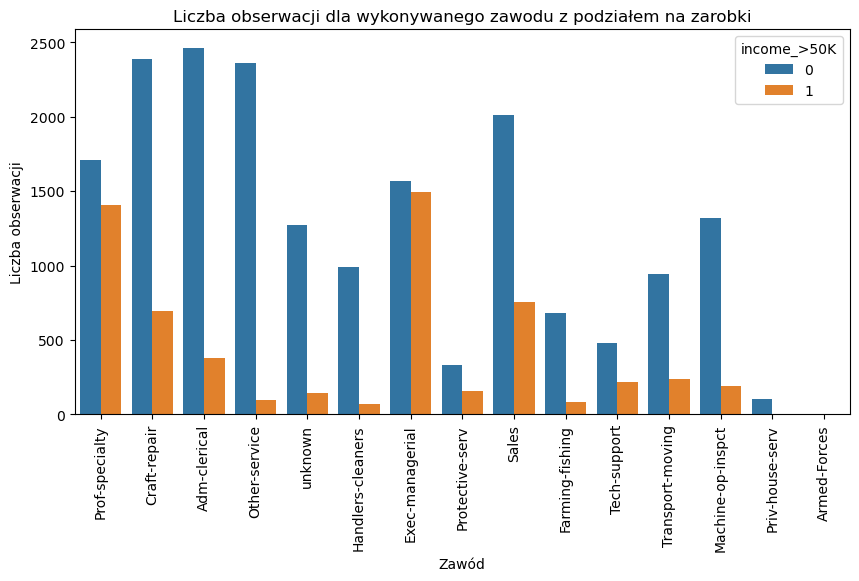

In [224]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='occupation', hue='income_>50K')
plt.title(f'Liczba obserwacji dla wykonywanego zawodu z podziałem na zarobki')
plt.xlabel('Zawód')
plt.ylabel('Liczba obserwacji')
plt.xticks(rotation=90)
plt.show()

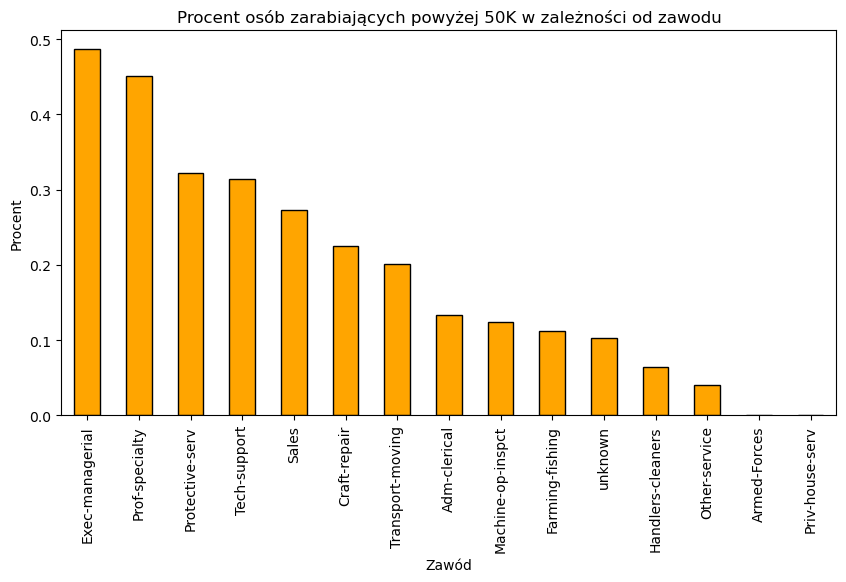

In [225]:
# Obliczenie procentów
occupation_income = df.groupby(['occupation', 'income_>50K']).size().unstack()
occupation_percent = occupation_income.div(occupation_income.sum(axis=1), axis=0)

# Wykres
occupation_percent[1].sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color='orange', edgecolor='black')
plt.title('Procent osób zarabiających powyżej 50K w zależności od zawodu')
plt.xlabel('Zawód')
plt.ylabel('Procent')
plt.show()


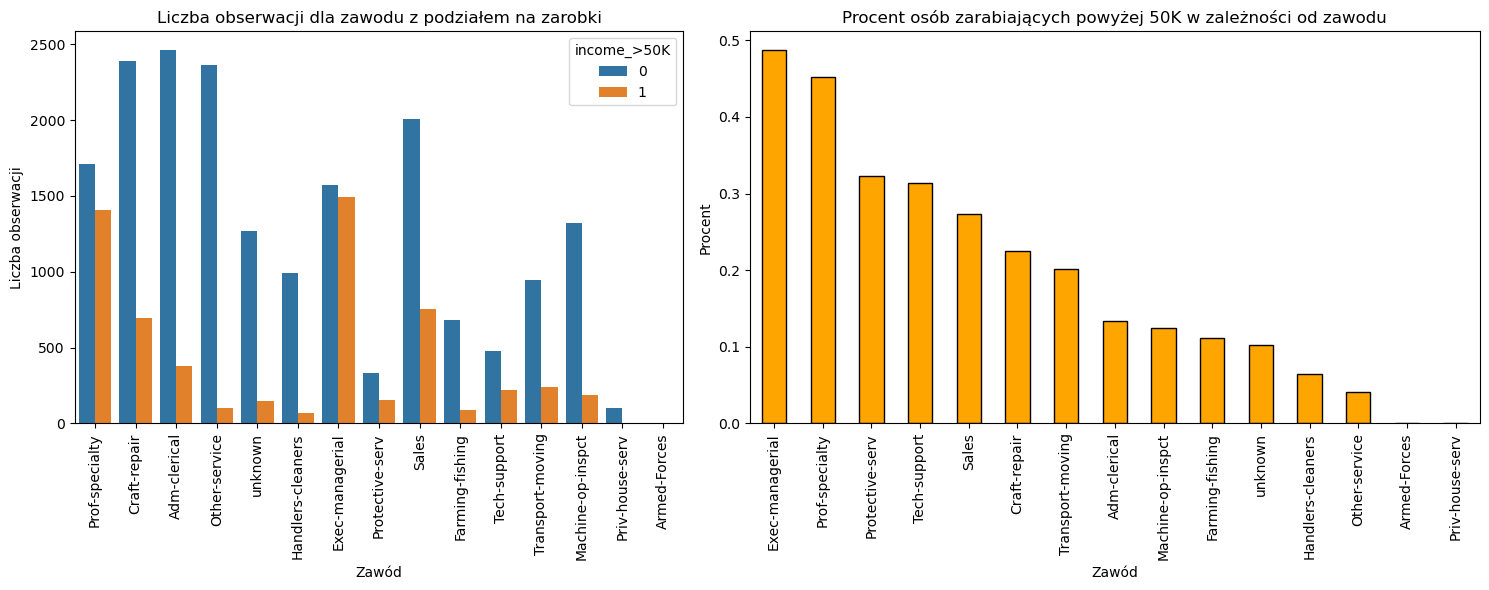

In [226]:
# Utworzenie figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1.2]})

# Wykres 1: Liczba obserwacji
sns.countplot(data=df, x='occupation', hue='income_>50K', ax=axes[0])
axes[0].set_title('Liczba obserwacji dla zawodu z podziałem na zarobki')
axes[0].set_xlabel("Zawód")
axes[0].set_ylabel('Liczba obserwacji')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(title='income_>50K', loc='upper right')

# Obliczenie procentów
occupation_income = df.groupby(['occupation', 'income_>50K']).size().unstack()
occupation_percent = occupation_income.div(occupation_income.sum(axis=1), axis=0)

# Wykres 2: Procent osób zarabiających powyżej 50K
occupation_percent[1].sort_values(ascending=False).plot(
    kind='bar', color='orange', edgecolor='black', ax=axes[1]
)
axes[1].set_title('Procent osób zarabiających powyżej 50K w zależności od zawodu')
axes[1].set_xlabel('Zawód')
axes[1].set_ylabel('Procent')
axes[1].tick_params(axis='x', rotation=90)

# Ustawienie odstępów między wykresami
plt.tight_layout()
plt.show()



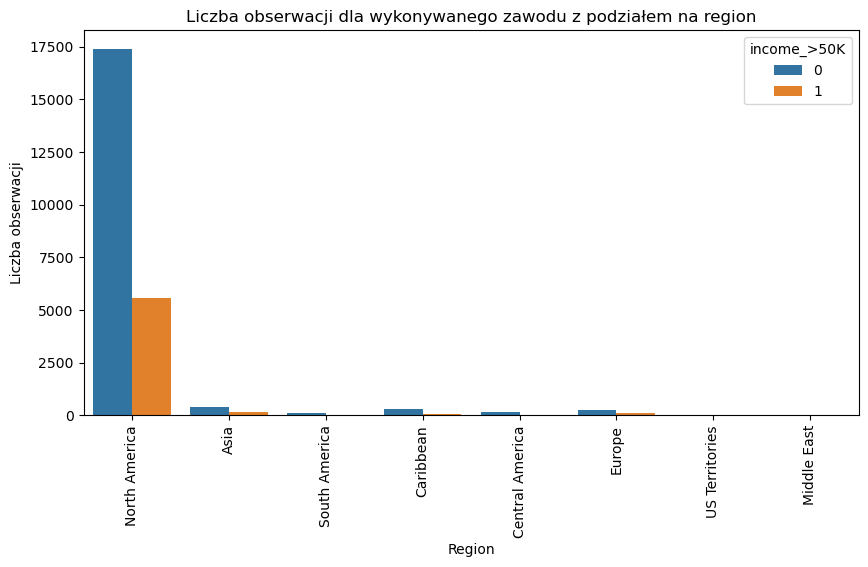

In [227]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='native.region', hue='income_>50K')
plt.title(f'Liczba obserwacji dla wykonywanego zawodu z podziałem na region')
plt.xlabel('Region')
plt.ylabel('Liczba obserwacji')
plt.xticks(rotation=90)
plt.show()

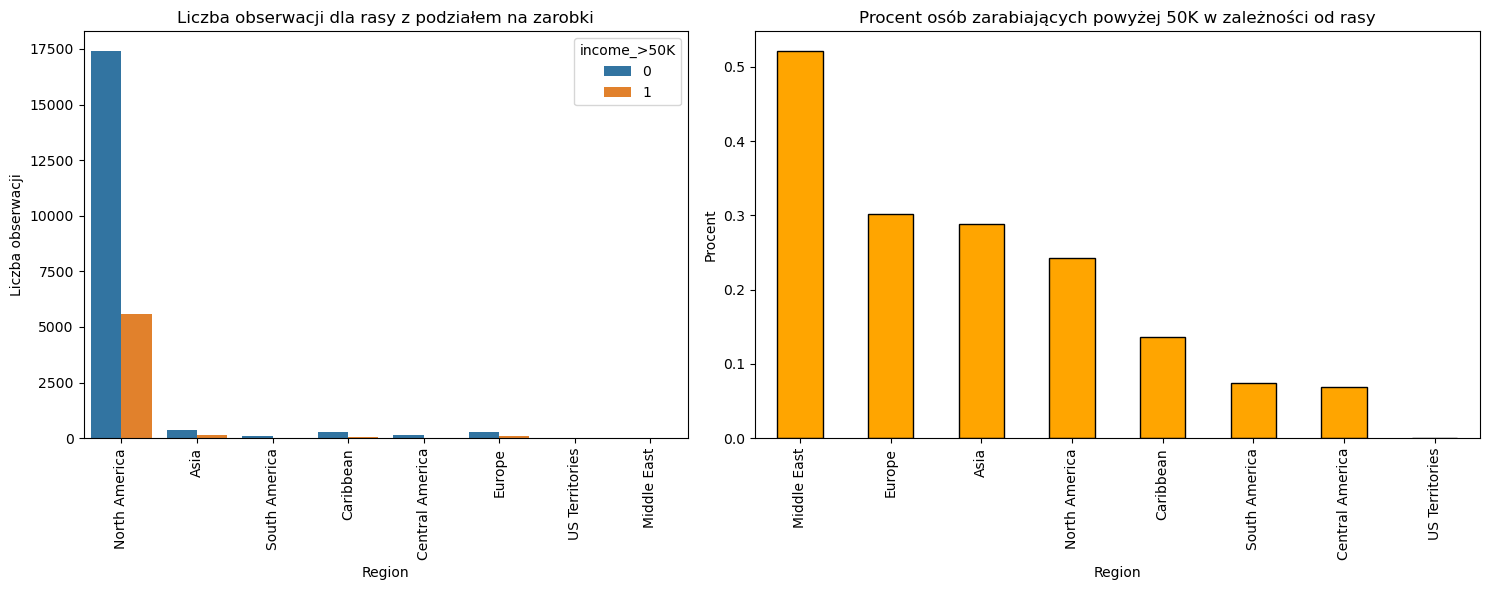

In [228]:
# Utworzenie figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1.2]})

# Wykres 1: Liczba obserwacji
sns.countplot(data=df, x='native.region', hue='income_>50K', ax=axes[0])
axes[0].set_title('Liczba obserwacji dla rasy z podziałem na zarobki')
axes[0].set_xlabel("Region")
axes[0].set_ylabel('Liczba obserwacji')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(title='income_>50K', loc='upper right')

# Obliczenie procentów
region_income = df.groupby(['native.region', 'income_>50K']).size().unstack()
region_percent = region_income.div(region_income.sum(axis=1), axis=0)

# Wykres 2: Procent osób zarabiających powyżej 50K
region_percent[1].sort_values(ascending=False).plot(
    kind='bar', color='orange', edgecolor='black', ax=axes[1]
)
axes[1].set_title('Procent osób zarabiających powyżej 50K w zależności od rasy')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Procent')
axes[1].tick_params(axis='x', rotation=90)

# Ustawienie odstępów między wykresami
plt.tight_layout()
plt.show()



### 2. Ostateczny wybór zmiennych oraz przygotowanie danych do budowy modelu.

Na podstawie analizy zależności oraz wartości **IV (Information Value)**, dokonaliśmy wyboru zmiennych, które zostaną uwzględnione w modelu:

1. **Zależności i wybór zmiennych:**
   - **Para: `native.region` i `race`**  
     Wartości IV:  
     - `native.region`: **0.0282** (bardzo niska predykcyjna moc)  
     - `race`: **0.0627** (nadal niska, ale lepsza)  

     **Decyzja:** Pozostawiamy zmienną **race**, ponieważ ma wyższą wartość IV i lepszą predykcyjną moc.

   - **Para: `workclass` i `occupation`**  
     Wartości IV:  
     - `workclass`: **0.1649** (umiarkowana predykcyjna moc)  
     - `occupation`: **0.8165** (silna predykcyjna moc)  

     **Decyzja:** Pozostawiamy zmienną **occupation**, ponieważ ma znacznie wyższą wartość IV i lepiej wyjaśnia zmienną celu.

   - **Para: `relationship` i `marital.status`**  
     Wartości IV:  
     - `relationship`: **1.5394** (bardzo silna predykcyjna moc)  
     - `marital.status`: **1.3277** (również bardzo silna, ale niższa)  

     **Decyzja:** Pozostawiamy zmienną **relationship**, ponieważ ma najwyższą wartość IV spośród obu zmiennych.

2. **Zależność `education` i `education.num`:**
   Zmienna `education` (kategoria) i `education.num` (jej numeryczny odpowiednik) są w sposób oczywisty zależne.  
   **Decyzja:** Pozostawiamy zmienną **education.num**, ponieważ modele lepiej radzą sobie z wartościami liczbowymi.


In [229]:
df = df.drop(columns=['education', 'marital.status', 'capital.loss', 'capital.gain', 'native.region', 'workclass'])

In [230]:
df.head()

,age,fnlwgt,education.num,occupation,relationship,race,sex,hours.per.week,net.capital,income_>50K
0,40,223881,15,Prof-specialty,Husband,White,Male,70,99999,1
1,30,149118,9,Craft-repair,Not-in-family,White,Female,40,0,0
2,46,109209,10,Adm-clerical,Husband,White,Male,40,0,1
3,32,229566,11,Other-service,Husband,White,Male,60,0,1
4,54,148657,1,unknown,Wife,White,Female,40,0,0


In [231]:
def plot_confusion_matrix(y_true, y_pred, labels, cmap, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_with_labels = pd.DataFrame(conf_matrix, columns=labels, index=labels)
    sns.heatmap(conf_matrix_with_labels, annot=True, fmt='d', cmap=cmap)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

In [232]:
def evaluate_model(model, X_train, y_train, X_test, y_test, labels=('neg', 'pos'), cmap='Blues'):
    """
    Funkcja do obliczania i wyświetlania metryk modelu, wizualizacji macierzy konfuzji
    oraz wyświetlania raportu klasyfikacji.

    Parametry:
    - model: sklearn-like model
        Wytrenowany model predykcyjny.
    - X_train, Y_train: array-like
        Dane treningowe i ich etykiety.
    - X_test, Y_test: array-like
        Dane testowe i ich etykiety.
    - labels: tuple, optional
        Etykiety dla osi macierzy konfuzji (domyślnie ('neg', 'pos')).
    - cmap: str, optional
        Kolorystyka mapy cieplnej (domyślnie 'Blues').

    Returns:
    - None
    """

    # Metryki dla danych treningowych
    y_pred_train = model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    auc_train = roc_auc_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    print('Metryki dla danych treningowych:')
    print(f'Accuracy: {acc_train:.4f}')
    print(f'AUC: {auc_train:.4f}')
    print(f'F1: {f1_train:.4f}')
    print('\nClassification Report dla danych treningowych:')
    print(classification_report(y_train, y_pred_train))

    # Wizualizacja macierzy konfuzji dla danych treningowych
    plot_confusion_matrix(y_train, y_pred_train, labels, cmap, 'Confusion Matrix (Train)')

    # Metryki dla danych testowych
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    print('\nMetryki dla danych testowych:')
    print(f'Accuracy: {acc_test:.4f}')
    print(f'AUC: {auc_test:.4f}')
    print(f'F1: {f1_test:.4f}')
    print('\nClassification Report dla danych testowych:')
    print(classification_report(y_test, y_pred_test))

    # Wizualizacja macierzy konfuzji dla danych testowych
    plot_confusion_matrix(y_test, y_pred_test, labels, cmap, 'Confusion Matrix (Test)')


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24563 entries, 0 to 24999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             24563 non-null  int64 
 1   fnlwgt          24563 non-null  int64 
 2   education.num   24563 non-null  int64 
 3   occupation      24563 non-null  object
 4   relationship    24563 non-null  object
 5   race            24563 non-null  object
 6   sex             24563 non-null  object
 7   hours.per.week  24563 non-null  int64 
 8   net.capital     24563 non-null  int64 
 9   income_>50K     24563 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 2.1+ MB


Zamiana zmiennych kategorycznych **occupation**, **relationship**, **race**, **sex** na zmienne binarne za pomocą metody **one hot encoding**:

In [234]:
columns = ['occupation', 'relationship', 'race', 'sex']
df = pd.get_dummies(df,columns=columns, drop_first=True, dtype=int)
df.head()

,age,fnlwgt,education.num,hours.per.week,net.capital,income_>50K,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,40,223881,15,70,99999,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,30,149118,9,40,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,46,109209,10,40,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,32,229566,11,60,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,54,148657,1,40,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


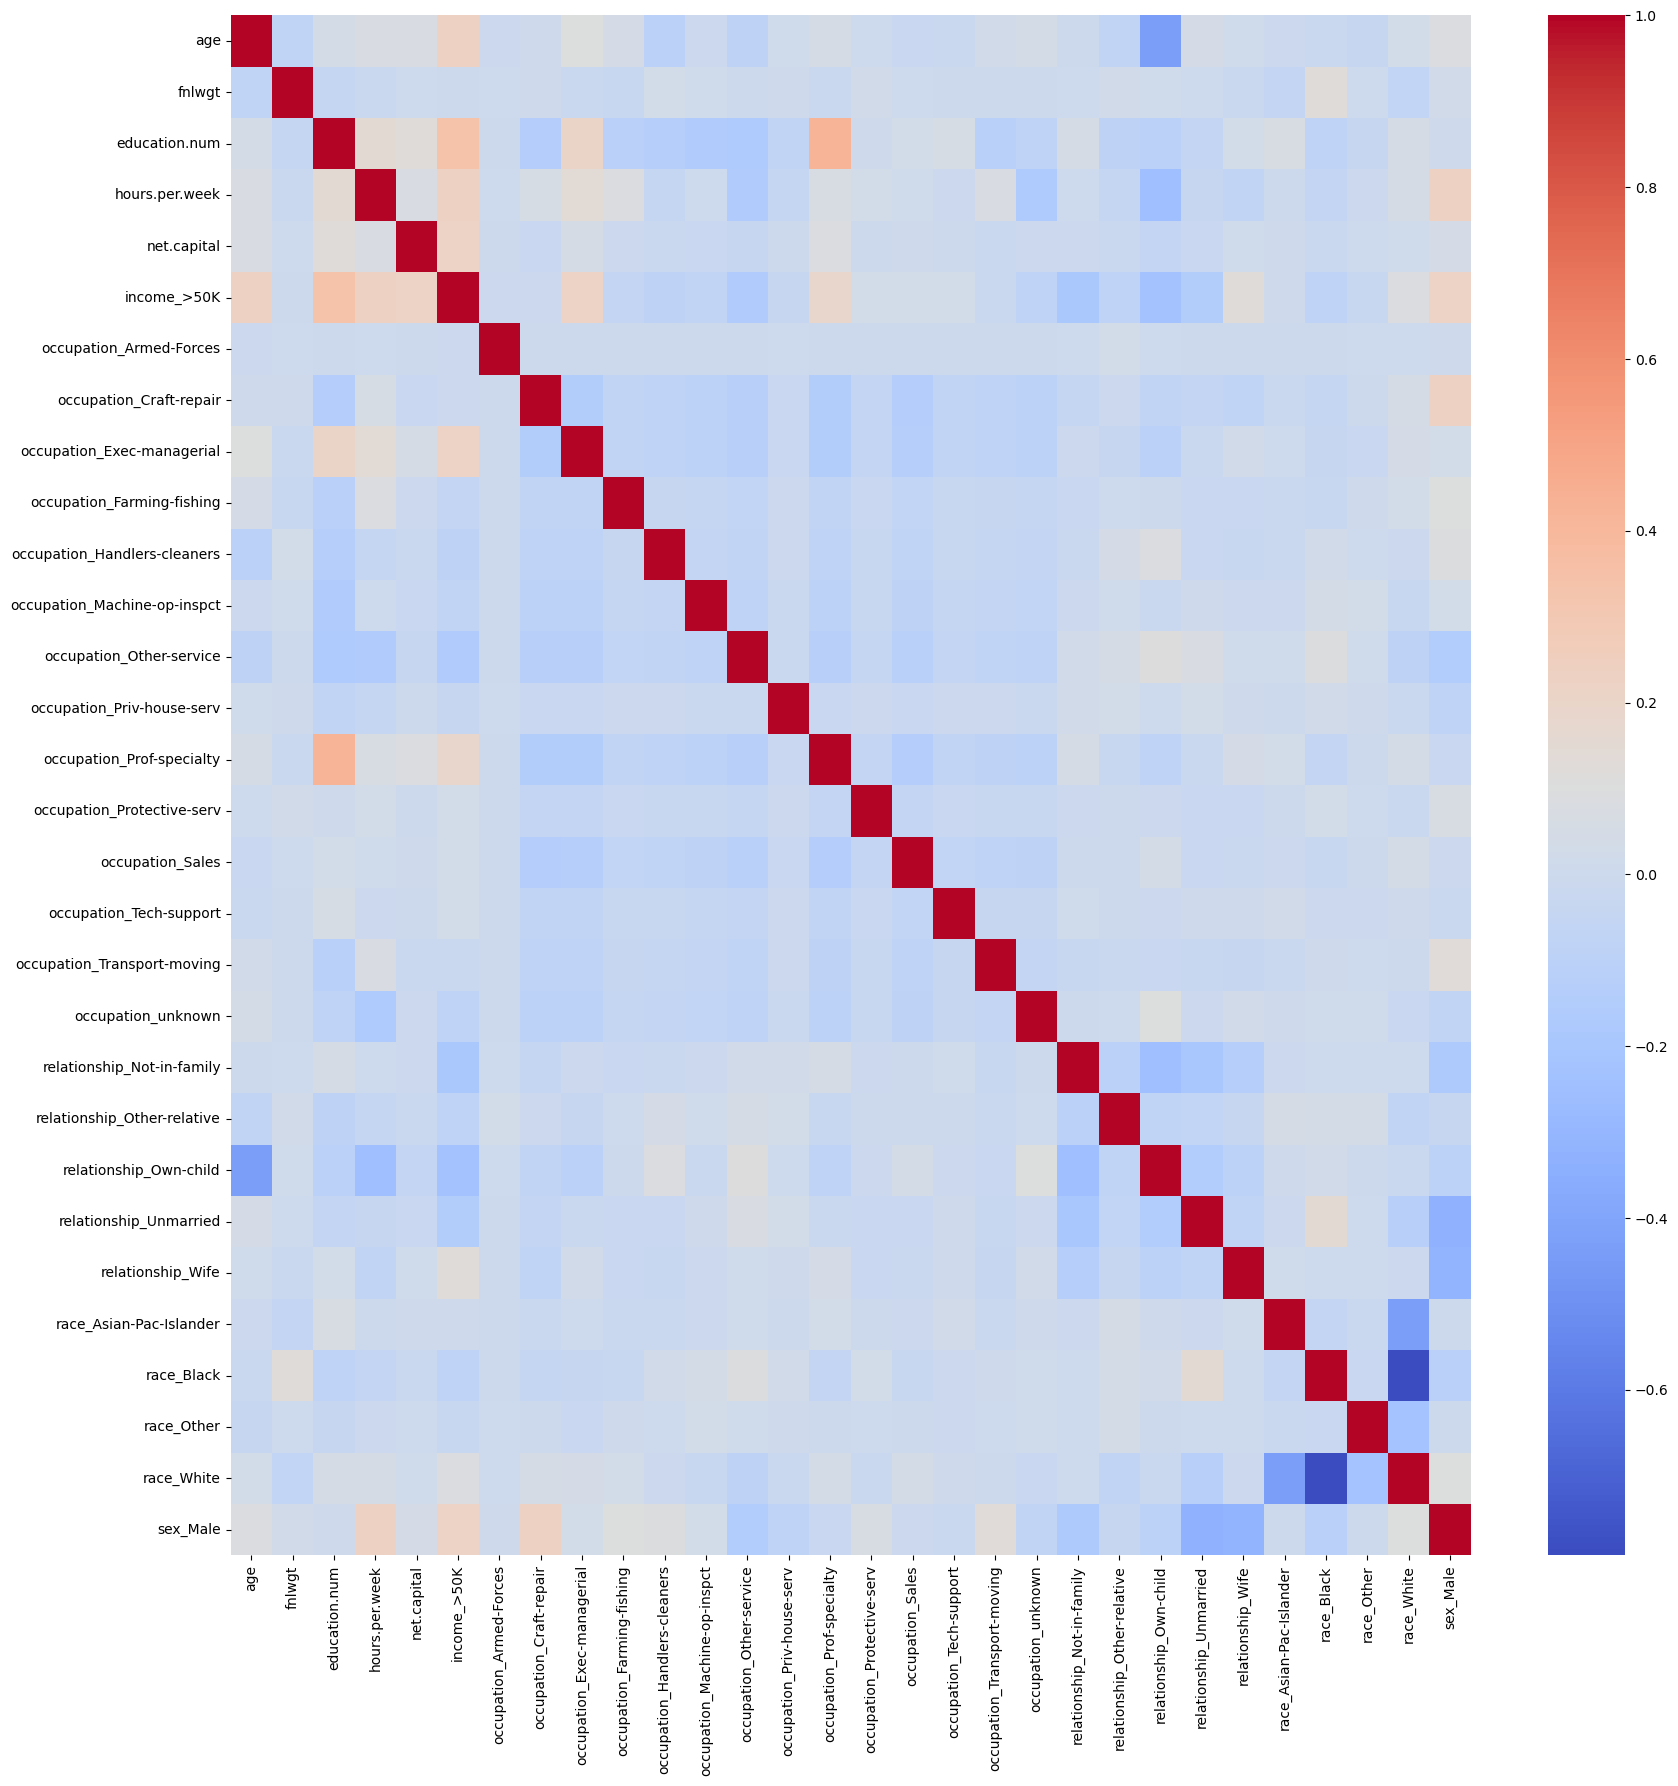

In [235]:
#plot heatmap 
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=False, fmt='.2f', cmap='coolwarm')
plt.show()


In [236]:
#check for correlation over 0.7
corr_matrix = df.corr().abs()
high_corr_var = np.where(corr_matrix > 0.7)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
high_corr_var

[('race_Black', 'race_White')]

#### Podział zmiennych na dane treningowe i testowe.
Dokonujemy podziału danych na zestawy treningowy i testowy, aby zapewnić, że zbiór testowy pozostaje "niewidoczny" podczas procesu przygotowania danych i modelowania.

In [237]:
X = df.drop(columns=['income_>50K'])
y = df['income_>50K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [238]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

#### Zbalansowanie zbioru danych.
Szukamy najlepszej metody na zbalansowanie zbioru danych. 
Balansowanie danych przeprowadzamy tylko na zbiorze treningowym, ponieważ zbiór testowy musi odzwierciedlać rzeczywisty rozkład danych.

# Do Adriana - musimy się zastanowić, czy jest sens zeby "szukac" najlepszej metody tutaj na to zbalansowanie, bo i tak za każdym razem model wychodzi nam przeuczony wiec ta interpretacja imo jest taka 50/50. Ja bym poszła odrazu w SMOTE i Tomka bez testowania.

In [239]:
from sklearn.metrics import precision_score, recall_score

methods = [SMOTE(), ADASYN(), BorderlineSMOTE(), SVMSMOTE(), RandomOverSampler()]
results_oversampling = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'Recall', 'Specificity'])

for method in methods:
    X_resampled, y_resampled = method.fit_resample(X_train, y_train)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_resampled, y_resampled)
    y_test_pred = model.predict(X_test)
    
    # Dodanie nowego wiersza jako DataFrame
    new_row = pd.DataFrame({
        'Method': [str(method)],
        'Accuracy': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, zero_division=0)],
        'Specificity': [specificity_score(y_test, y_test_pred)]
    })
    
    # Połączenie wyników
    results_oversampling = pd.concat([results_oversampling, new_row], ignore_index=True)

results_oversampling


/var/folders/hh/pvrf3bcn1_19pfvwcv0z6n_m0000gn/T/ipykernel_81119/3401671582.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_oversampling = pd.concat([results_oversampling, new_row], ignore_index=True)


,Method,Accuracy,Precision,Recall,Specificity
0,SMOTE(),0.843805,0.676403,0.668364,0.899143
1,ADASYN(),0.841091,0.668552,0.668930,0.895395
2,BorderlineSMOTE(),0.845162,0.677841,0.675156,0.898786
3,SVMSMOTE(),0.844891,0.676670,0.676287,0.898072
4,RandomOverSampler(),0.844484,0.672981,0.683645,0.895216


In [240]:
methods = [RandomUnderSampler(), NearMiss(), TomekLinks(), ClusterCentroids(), AllKNN()]
results_undersampling = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'Recall', 'Specificity'])

for method in methods:
    X_resampled, y_resampled = method.fit_resample(X_train, y_train)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_resampled, y_resampled)
    y_test_pred = model.predict(X_test)
    
    new_row = pd.DataFrame({
        'Method': [str(method)],
        'Accuracy': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, zero_division=0)],
        'Specificity': [specificity_score(y_test, y_test_pred)]
    })
    
    # Połączenie wyników
    results_undersampling = pd.concat([results_undersampling, new_row], ignore_index=True)

results_undersampling

/var/folders/hh/pvrf3bcn1_19pfvwcv0z6n_m0000gn/T/ipykernel_81119/3056045029.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_undersampling = pd.concat([results_undersampling, new_row], ignore_index=True)


,Method,Accuracy,Precision,Recall,Specificity
0,RandomUnderSampler(),0.815443,0.580467,0.830787,0.810603
1,NearMiss(),0.761162,0.501186,0.837012,0.737237
2,TomekLinks(),0.851405,0.703636,0.657046,0.912710
3,ClusterCentroids(),0.684218,0.427348,0.932088,0.606034
4,AllKNN(),0.822364,0.597447,0.794567,0.831132


Zastosujmy połączenie moetody **SMOTE** z **Tomek Links**.

Metryki dla danych treningowych:
Accuracy: 0.9999
AUC: 0.9999
F1: 0.9999

Classification Report dla danych treningowych:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11617
           1       1.00      1.00      1.00     11617

    accuracy                           1.00     23234
   macro avg       1.00      1.00      1.00     23234
weighted avg       1.00      1.00      1.00     23234



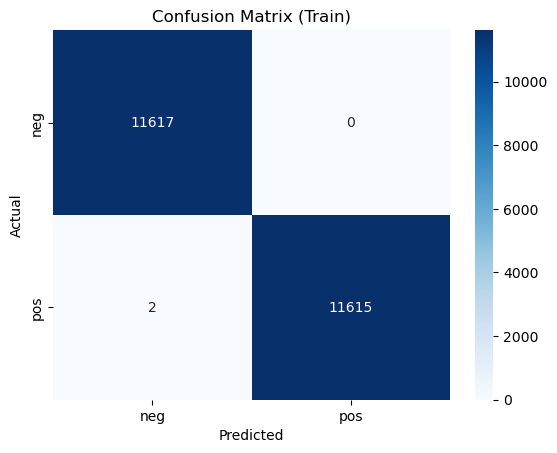


Metryki dla danych testowych:
Accuracy: 0.8415
AUC: 0.7929
F1: 0.6791

Classification Report dla danych testowych:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5602
           1       0.66      0.70      0.68      1767

    accuracy                           0.84      7369
   macro avg       0.78      0.79      0.79      7369
weighted avg       0.85      0.84      0.84      7369



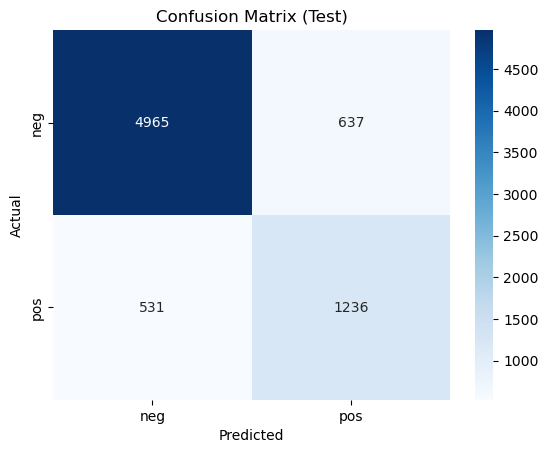

In [241]:
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)
evaluate_model(model, X_resampled, y_resampled, X_test, y_test)

#### Skalowanie danych

Teraz przystąpimy do skalowania danych. Skalowanie jest konieczne, aby znormalizować wartości cech i zapewnić, że wszystkie zmienne są na tej samej skali. Jest to szczególnie ważne w przypadku algorytmów, które są wrażliwe na różnice w skali cech, takich jak SVM, kNN czy regresja logistyczna.

**Proces:**
1. Fitujemy skaler na zbiorze treningowym, aby dopasować go do danych treningowych.  
2. Skalujemy zarówno zbiór treningowy, jak i testowy, używając skalera wytrenowanego na zbiorze treningowym.  

Dzięki temu unikniemy przeciekania informacji ze zbioru testowego do modelu i zapewnimy poprawność procesu walidacji.


In [242]:
scaler = StandardScaler()
X_resampled[['fnlwgt', 'education.num','hours.per.week', 'net.capital', 'age']] = scaler.fit_transform(X_resampled[['fnlwgt', 'education.num','hours.per.week', 'net.capital', 'age']])
X_test[['fnlwgt', 'education.num','hours.per.week', 'net.capital', 'age']] = scaler.transform(X_test[['fnlwgt', 'education.num','hours.per.week', 'net.capital', 'age']])

In [243]:
df.describe()

,age,fnlwgt,education.num,hours.per.week,net.capital,income_>50K,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
count,24563.000000,2.456300e+04,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,...,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000
mean,38.610837,1.895654e+05,10.067418,40.427432,979.171315,0.241624,0.000244,0.125514,0.124740,0.031226,...,0.253756,0.029475,0.156658,0.106624,0.047999,0.030045,0.095469,0.007979,0.856247,0.667915
std,13.708100,1.056348e+05,2.565138,12.308670,7237.756530,0.428076,0.015628,0.331308,0.330431,0.173931,...,0.435168,0.169138,0.363486,0.308641,0.213769,0.170715,0.293867,0.088973,0.350846,0.470971
min,17.000000,1.228500e+04,1.000000,1.000000,-4356.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.177790e+05,9.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,37.000000,1.779950e+05,10.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,48.000000,2.373790e+05,12.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,90.000000,1.484705e+06,16.000000,99.000000,99999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [244]:
model = RandomForestClassifier(random_state=42)

# Siatka hiperparametrów
param_grid = {
    'n_estimators': [3, 5, 10, 20, 50, 100],
    'max_depth': [None, 5, 10, 20, 30],
}


In [245]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # Możesz zmienić na inne, np. 'f1', 'roc_auc', 'neg_mean_squared_error'
    cv=5,  # Liczba podziałów walidacji krzyżowej
    verbose=2,  # Wyświetlanie postępu
    n_jobs=-1  # Użycie wszystkich rdzeni procesora
)


In [246]:
grid_search.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.0s
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=5; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=5; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=5; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=5; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=5; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.1s
[CV] END ....................max_depth=None, n_

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20, 30],
                         'n_estimators': [3, 5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=2)

In [247]:
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

Najlepsze parametry: {'max_depth': 20, 'n_estimators': 100}
Najlepszy wynik: 0.8812103050482442


In [248]:
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Dokładność na zbiorze testowym:", test_score)

Dokładność na zbiorze testowym: 0.8406839462613652


### Support Vector Machine (SVM)

W przypadku modelu SVM zastosowano wyszukiwanie optymalnych parametrów przy użyciu GridSearchCV. Główne hiperparametry i ich znaczenie to:

- **C**: Parametr regularyzacji. Wyższe wartości oznaczają mniejszą karę za błąd klasyfikacji, co może prowadzić do przeuczenia. Testowano wartości `[0.1, 1, 10, 100]`.
- **kernel**: Rodzaj funkcji jądra. Wybrano najbardziej popularne jądra: `linear`, `poly` (wielomianowe) oraz `rbf` (funkcja radialna), aby dostosować model do nieliniowych zależności.
- **degree**: Stopień wielomianu dla jądra `poly`. Testowano wartości `[2, 3, 4, 5]`.
- **gamma**: Parametr wpływający na działanie jąder `rbf` i `poly`. Sprawdzono wartości `scale` i `auto`.

Siatka parametrów pozwala dostosować model zarówno do liniowych, jak i nieliniowych problemów klasyfikacji. 
Optymalne parametry uzyskane z GridSearch są następnie używane do oceny skuteczności modelu.


In [249]:

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['linear', 'poly', 'rbf'], 
    'degree': [2, 3, 4, 5], 
    'gamma': ['scale', 'auto']}
grid_svc = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, n_jobs=-1)
# grid_svc.fit(X_resampled, y_resampled)
# grid_svc.best_params_

In [250]:
# evaluate_model(grid_svc.best_estimator_, X_resampled, y_resampled, X_test, y_test)

### k-Nearest Neighbors (kNN)

Dla modelu kNN zastosowano GridSearchCV, aby znaleźć najlepsze parametry. Wybrano następujące hiperparametry:

- **n_neighbors**: Liczba sąsiadów branych pod uwagę podczas klasyfikacji. Testowano wartości `[3, 5, 7, 9, 11, 13, 15]`, aby znaleźć kompromis między dokładnością a generalizacją.
- **weights**: Sposób ważenia sąsiadów. `uniform` oznacza równą wagę, a `distance` przypisuje większą wagę bliższym sąsiadom.
- **metric**: Metryka odległości. Przetestowano `euclidean` (euklidesową) i `manhattan`, aby ocenić wpływ różnych sposobów mierzenia odległości na wyniki.

Te hiperparametry pozwalają dostosować model do danych o różnym charakterze i rozkładzie.


In [251]:
param_grid = {
    'n_neighbors': np.arange(1, 100,2),
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan']}
grid_kknn = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=2, n_jobs=-1)
grid_kknn.fit(X_resampled, y_resampled)
grid_kknn.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=3, 

{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}

Metryki dla danych treningowych:
Accuracy: 0.9999
AUC: 0.9999
F1: 0.9999

Classification Report dla danych treningowych:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11617
           1       1.00      1.00      1.00     11617

    accuracy                           1.00     23234
   macro avg       1.00      1.00      1.00     23234
weighted avg       1.00      1.00      1.00     23234



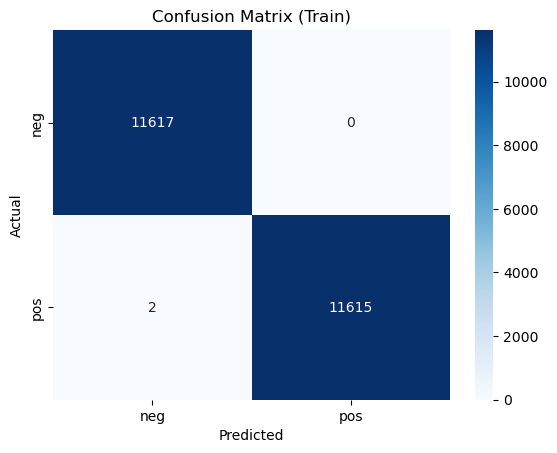


Metryki dla danych testowych:
Accuracy: 0.8087
AUC: 0.7860
F1: 0.6505

Classification Report dla danych testowych:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      5602
           1       0.58      0.74      0.65      1767

    accuracy                           0.81      7369
   macro avg       0.74      0.79      0.76      7369
weighted avg       0.83      0.81      0.82      7369



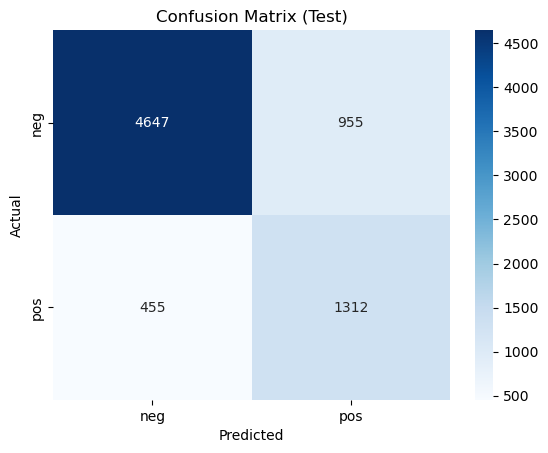

In [252]:

#evaluate model kkn with best params
evaluate_model(grid_kknn.best_estimator_, X_resampled, y_resampled, X_test, y_test)

### Logistic Regression

Regresja logistyczna jest klasycznym modelem liniowym, ale jej skuteczność może być poprawiona dzięki odpowiedniemu dostrojeniu parametrów:

- **C**: Parametr regularyzacji. Testowano wartości `[0.01, 0.1, 1, 10, 100]`, gdzie mniejsze wartości zwiększają regularyzację, co pomaga uniknąć przeuczenia.
- **penalty**: Typ regularyzacji (`l1`, `l2`, `elasticnet`, `none`). Pozwala na dopasowanie modelu do różnych typów danych, np. rzadkich lub z dużą liczbą cech.
- **solver**: Algorytm optymalizacji (`liblinear`, `saga`, `lbfgs`, `newton-cg`). Wybrano różne algorytmy, aby ocenić ich wydajność w zależności od wybranego typu regularyzacji.
- **max_iter**: Maksymalna liczba iteracji. Testowano `[100, 200, 500]` w celu zapewnienia zbieżności modelu dla różnych danych.
- **fit_intercept**: Czy model powinien dopasowywać wyraz wolny. Testowano `True` i `False`.
- **tol**: Tolerancja zbieżności (`1e-4, 1e-3, 1e-2`), aby określić moment zakończenia iteracji optymalizacyjnych.

Dzięki GridSearchCV model został dostrojony, aby osiągnąć jak najlepsze wyniki na niezbalansowanym zbiorze danych.


In [253]:

# Definicja siatki parametrów
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularyzacja (hiperparametr C)
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Typ regularyzacji
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],  # Algorytm optymalizacji
    'max_iter': [100, 200, 500],  # Maksymalna liczba iteracji
    'fit_intercept': [True, False],  # Czy dopasować wyraz wolny (intercept)
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerancja zbieżności
}

# Tworzenie obiektu GridSearchCV
grid_lr = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    refit=True,
    verbose=2,
    n_jobs=-1
)

# grid_lr.fit(X_resampled, y_resampled)
# grid_lr.best_params_

In [254]:
evaluate_model(grid_lr.best_estimator_, X_resampled, y_resampled, X_test, y_test)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'